# Лекция 4. Обучение без учителя в Scikit-learn

* [Введение](#intro)
* [Понижение размерности](#reduce)
    * [PCA -  Principal Component Analysis](#pca)
    * [TSNE](#tsne)
* [Кластеризация](#cluster)
    * [K-means](#kmeans)
    * [DBSCAN](#dbscan)
    * [Иерархическая](#aggl)
* [Наглядный пример](#example)

## Введение <a class='anchor' id='intro'>

Основное отличие методов обучения без учителя от привычных классификаций и регрессий машинного обучения в том, что разметки для данных в этом случае нет. От этого образуются сразу несколько особенностей — во-первых это возможность использования несопоставимо больших объёмов данных, поскольку их не нужно будет размечать руками для обучения, а во-вторых это неясность измерения качества методов, из-за отсутствия таких же прямолинейных и интуитивно понятных метрик, как в задачах обучения с учителем.

Одной из самых очевидных задач, которые возникают в голове в отсутствие явной разметки, является задача снижения размерности данных. С одной стороны её можно рассматривать как помощь в визуализации данных (для этого часто используется метод t-SNE). С другой стороны, подобное снижение размерности может убрать лишние сильно скоррелированные признаки у наблюдений и подготовить данные для дальнейшей обработки в режиме обучения с учителем, например сделать входные данные более "перевариваемыми" для деревьев решений.

1. Кластеризация
2. Понижение размерности - из N фичей сделать 2 или 3, и визуализировать<br>
    - Сжатие данных с сохранением смысла
    - Визуализация
    - Абстрактные признаки

<img src='https://i.stack.imgur.com/EE6kn.png' width=700px>



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Подключение библиотек и скриптов**

In [ ]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
matplotlib.rcParams.update({'font.size': 12})

In [ ]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):

    assert method in ['pca', 'tsne'], 'Неверно указан метод'

    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')

    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames)

In [ ]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'],
                   components_with_labels_df['component_2'],
                   components_with_labels_df['component_3'],
                   c=components_with_labels_df.iloc[:, -1],
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'],
                   components_with_labels_df['component_2'],
                   components_with_labels_df['component_3'],
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [ ]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""

    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [ ]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [ ]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))

    plt.figure(figsize=(10,10))

    sns.scatterplot(x=pred_values, y=true_values)

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

**Пути к директориям и файлам**

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_4/housing_prepared.csv'
TRAIN_DATASET_EXT_PATH = '/content/drive/My Drive/Colab Notebooks/Методы и средства реализации интеллектуальных задач/lection_4/housing_train_ext.csv'

### Загрузка данных

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [ ]:
df = pd.read_csv(TRAIN_DATASET_PATH, ';')
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
0       322.0       126.0         8.3252          0       0         1   
1      2401.0      1138.0         8.3014          0       0         1   
2       496.0       177.0         7.2574          0       0         1   
3       558.0       219.0         5.6431          0       0         1   
4       565.0       259.0         3.8462          0       0         1   

   NEAR OCEAN  median_house_value  
0           0            452600.0  
1           0            358500.0  
2           0            352100.0  
3           0            341300.0  
4           0            342200.0

In [ ]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
<1H OCEAN               int64
INLAND                  int64
NEAR BAY                int64
NEAR OCEAN              int64
median_house_value    float64
dtype: object

### Определение признакового пространства

In [ ]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value'].values

X.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   

   population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
0       322.0       126.0         8.3252          0       0         1   
1      2401.0      1138.0         8.3014          0       0         1   

   NEAR OCEAN  
0           0  
1           0

In [ ]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

## Масштабирование / Нормализация

$$dist(x, y) = \sqrt(\sum(x_i - y_i)^2)$$

In [ ]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min)
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = RobustScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.198413  0.245383           -1.388889    -1.254978       -1.251445   
1   0.230159 -0.068602           -0.722222     0.551857        0.257225   

   population  households  median_income  <1H OCEAN  INLAND  NEAR BAY  \
0   -1.265284   -1.264615      -0.516324        0.0     1.0       0.0   
1    0.383188    0.190769       0.715002        0.0     1.0       0.0   

   NEAR OCEAN  
0         0.0  
1         0.0

В _scaled все признаки измеряются в одних единицах

In [ ]:
X_train_scaled.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  13182.000000  13182.000000        13182.000000  13182.000000   
mean      -0.275141      0.367640           -0.031280      0.299628   
std        0.530962      0.568250            0.684297      1.286582   
min       -1.537037     -0.459103           -1.555556     -1.254978   
25%       -0.857143     -0.089710           -0.611111     -0.400743   
50%        0.000000      0.000000            0.000000      0.000000   
75%        0.142857      0.910290            0.388889      0.599257   
max        1.119048      2.023747            1.277778     21.291828   

       total_bedrooms    population    households  median_income  \
count    13182.000000  13182.000000  13182.000000   13182.000000   
mean         0.300403      0.295044      0.271802       0.113549   
std          1.206267      1.199331      1.168905       0.764799   
min         -1.251445     -1.266376     -1.264615      -1.434141   
25%         -0.395954     -0.386463     -0.406154      -0.445595   
50%          0.000000      0.000000      0.000000       0.000000   
75%          0.604046      0.613537      0.593846       0.554405   
max         14.554913     16.328603     14.695385       5.663363   

          <1H OCEAN        INLAND      NEAR BAY    NEAR OCEAN  
count  13182.000000  13182.000000  13182.000000  13182.000000  
mean       0.433697      0.333106      0.108481      0.123274  
std        0.495603      0.471342      0.310999      0.328764  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        1.000000      1.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000

Когда **необходимо** применять масштабирование/нормализацию:
- Во всех методах понижения размерности
- В линейной регрессии
- В KNN

Когда **не обязательно** использовать масштабирование/нормализацию:
- Дерево решений
- Случайный лес
- Градиентный бустинг

## Понижение размерности <a class='anchor' id='reduce'>

### PCA -  Principal Component Analysis (метод главных компонент) <a class='anchor' id='pca'>

Анализ главных компонент является одним из самых простых, интуитивно понятных и наиболее часто используемых методов уменьшения размерности, проецируя данные на его ортогональное подпространство объектов.

В более общем смысле, все наблюдения можно рассматривать как эллипсоид в подпространстве исходного пространства объектов, и новый базис, установленный в этом подпространстве, выровнен с осями эллипсоида. Это предположение позволяет нам удалить сильно коррелированные объекты, поскольку векторы базисного набора ортогональны. В общем случае результирующая размерность эллипсоида соответствует исходной размерности пространства, но предположение, что наши данные лежат в подпространстве с меньшей размерностью, позволяет нам отсечь “лишнее” пространство с помощью новой проекции (подпространства). Мы выполняем это ‘жадным’ способом, последовательно выбирая каждую из осей эллипсоида, определяя, где дисперсия максимальна.


**Пример. Из 2-мерного пространства в 1-мерное**

$$component_1 = a_1*X_1 + a_2*X_2$$

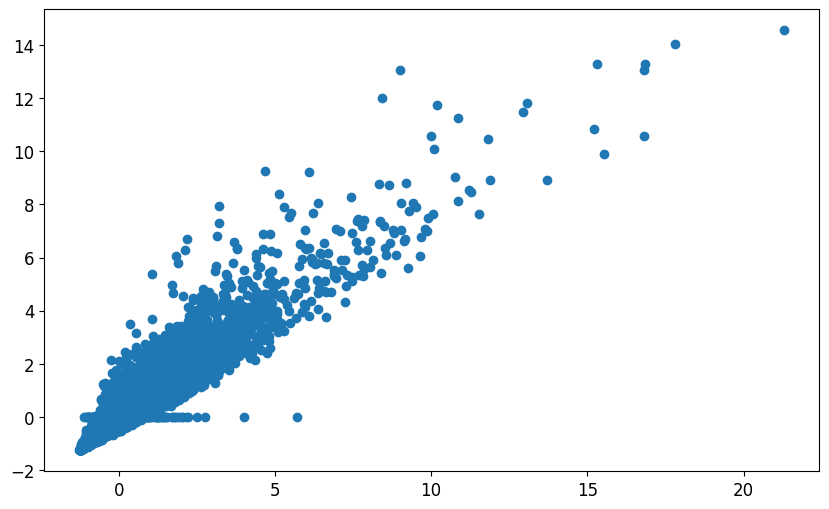

In [ ]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.show()

In [ ]:
X_small.head()

total_rooms  total_bedrooms  component_1
0    -1.254978       -1.251445    -2.195341
1     0.551857        0.257225     0.154976
2     0.987519        1.014451     0.990083
3     0.478752        0.210983     0.069976
4     2.190490        1.404624     2.135858

PCA подбирает такую линию, вдоль которой лежат точки

В линейной регресии минимизируется "вертикальная разница":
    $$(y - y_{pred})^2$$
    
В PCA минимизируется среднее расстояние от точек до линии - перпендикуляр к линии:
$$ \sqrt(x1_{i} - x1'_{i})^2 + (x2_{i} - x2'_{i})^2$$

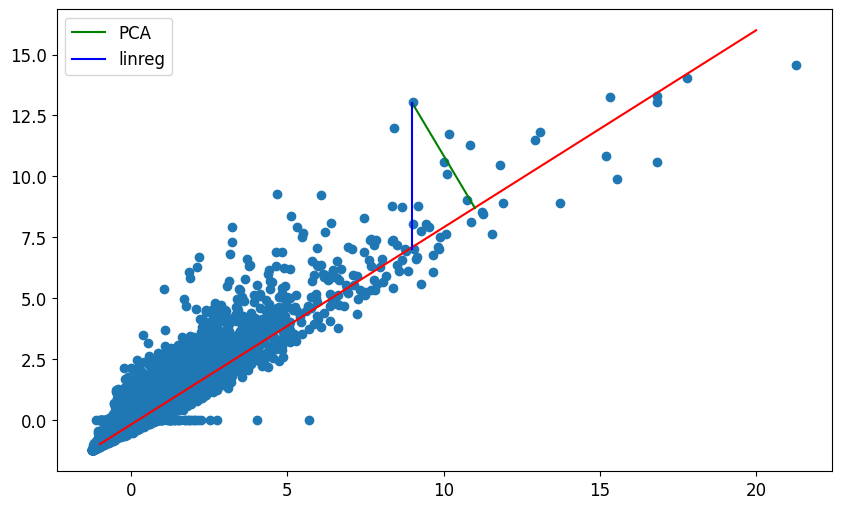

In [ ]:
X_small = X_train_scaled[['total_rooms', 'total_bedrooms']]

pca = PCA(n_components=1, random_state=42)
X_small['component_1'] = pca.fit_transform(X_small)

plt.figure(figsize=(10,6))
plt.scatter(X_small.total_rooms,  X_small.total_bedrooms)
plt.plot([-1, 20], [-1, 16], c='r')
plt.plot([9, 11], [13, 8.7], c='g', label='PCA')
plt.plot([9, 9], [13, 7], c='b', label='linreg')
plt.legend()
plt.show()

**Как работает PCA из 3d в 2d**

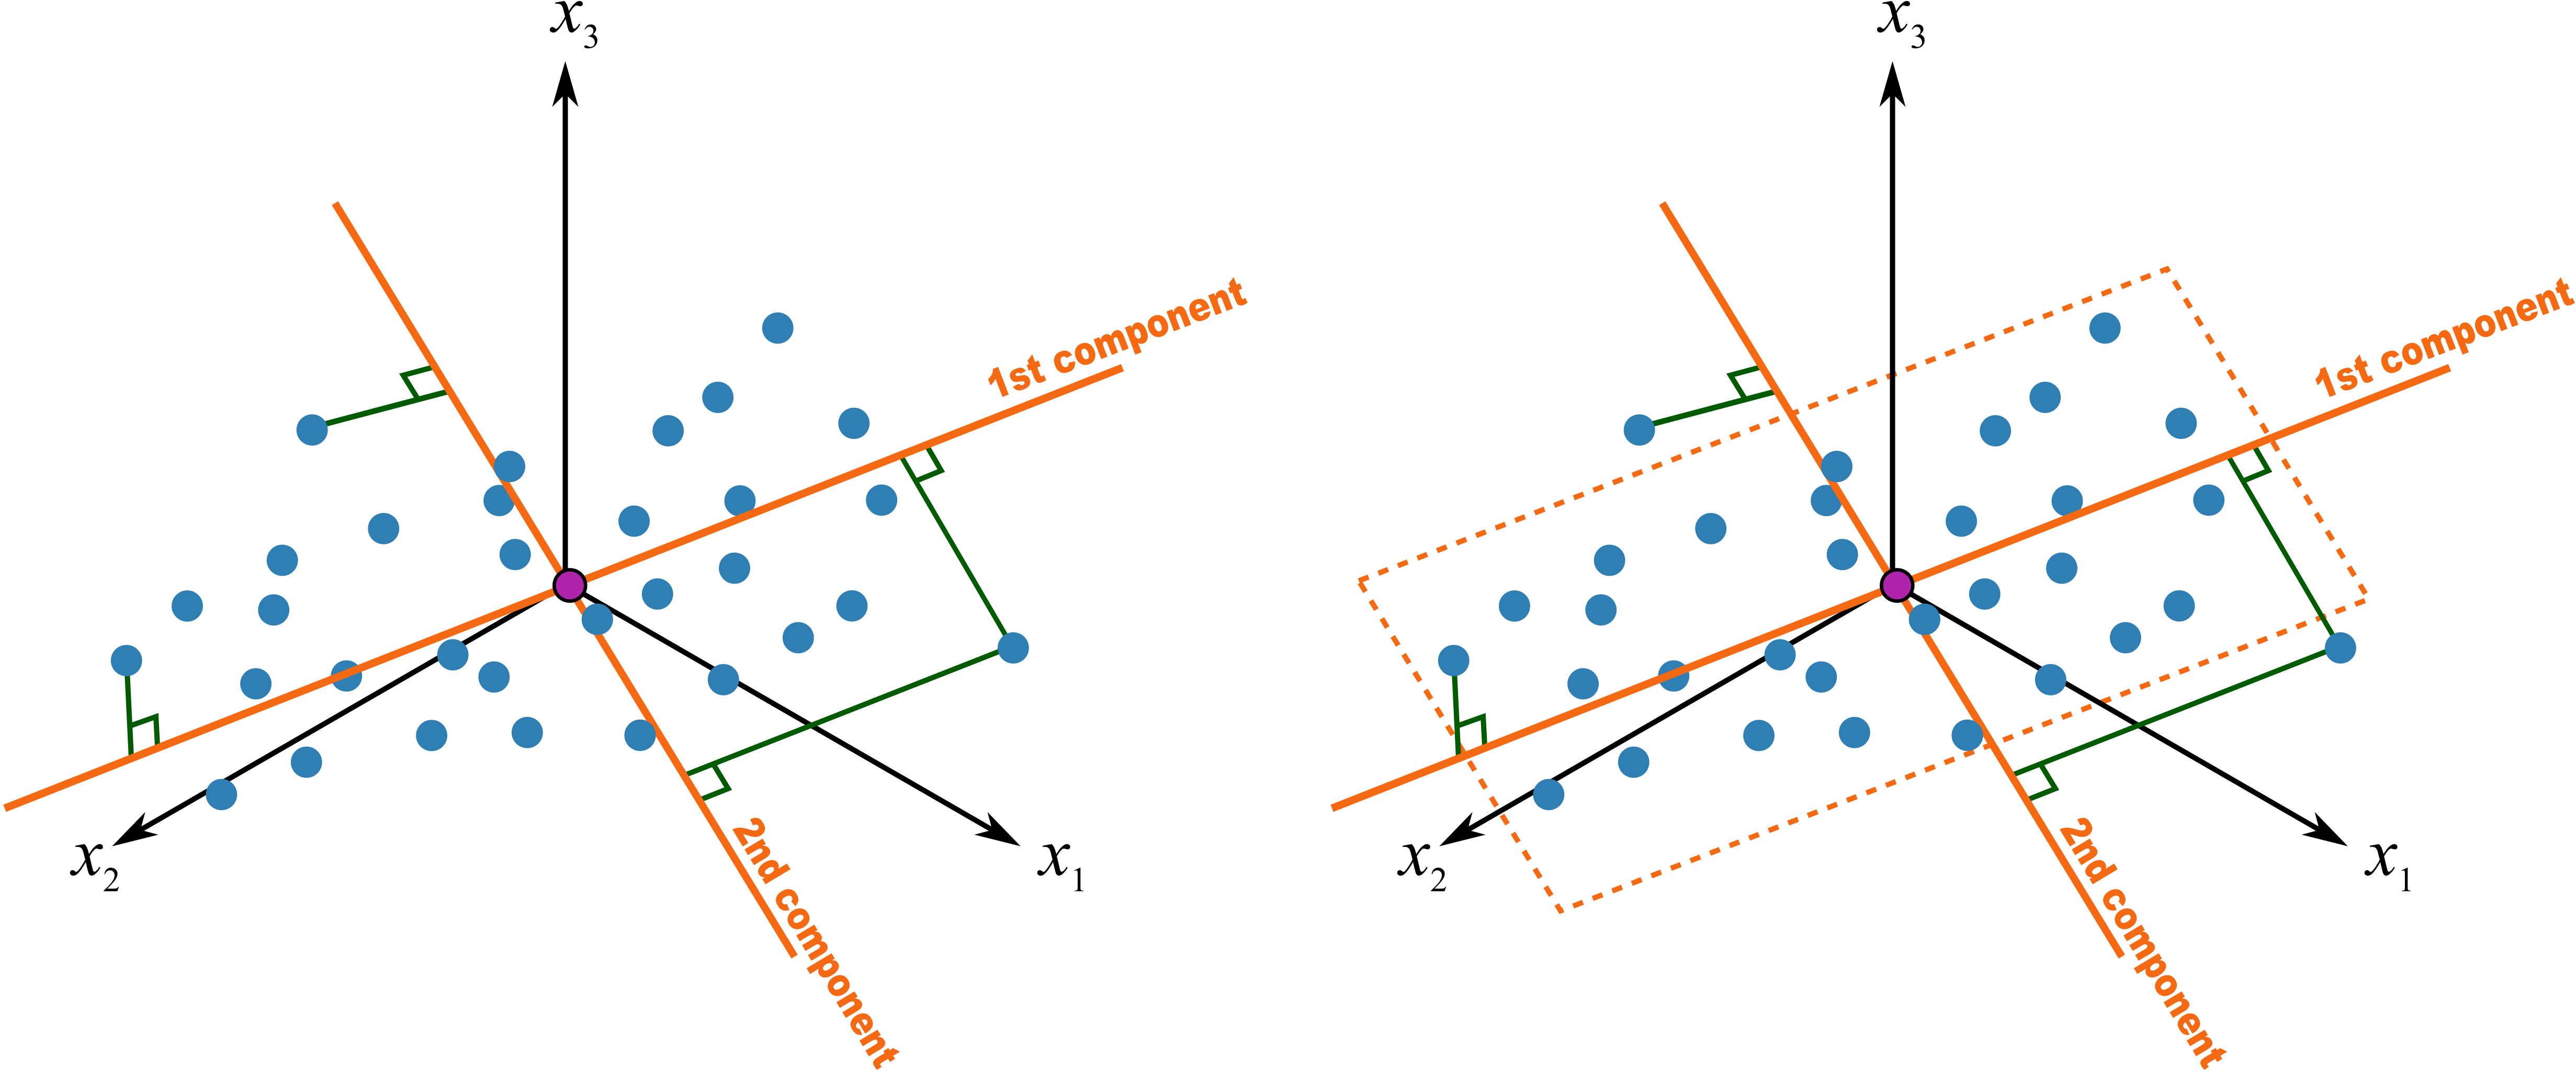

**Снижение размерности до 2х компонент**

In [ ]:
import inspect
print(inspect.getsource(reduce_dims))

def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 



In [ ]:
dim_reducer2d, components_2d = reduce_dims(X_train_scaled, dims=2, method='pca')
components_2d.head(2)

component_1  component_2
0    -2.951421    -0.121055
1     0.223307     0.502295

In [ ]:
X_train_scaled.shape, components_2d.shape

((13182, 12), (13182, 2))

In [ ]:
dim_reducer2d

PCA(n_components=2, random_state=42)

In [ ]:
dims = 2
components = dim_reducer2d.transform(X_test_scaled)
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_2d_test = pd.DataFrame(data = components, columns = colnames)
components_2d_test.head()

component_1  component_2
0     0.418202     0.491004
1    -0.474166     1.213368
2    -1.576050     0.212565
3    -1.223505    -0.853262
4    -0.066895    -1.385271

In [ ]:
print(inspect.getsource(display_components_in_2D_space))

def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()



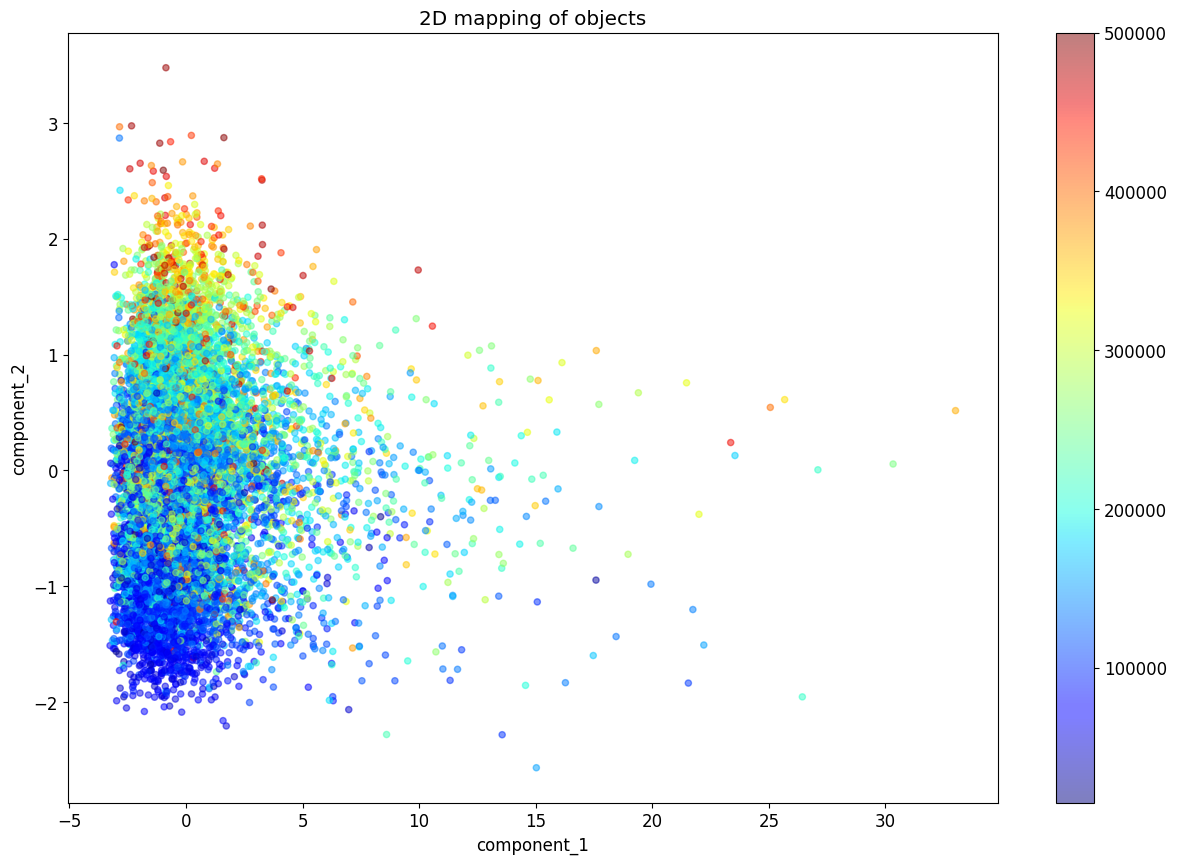

In [ ]:
display_components_in_2D_space(components_2d, y_train)

**Снижение размерности до 3х компонент**

In [ ]:
dim_reducer3d, components_3d = reduce_dims(X_train_scaled, dims=3, method='pca')

In [ ]:
dims = 3
components = dim_reducer3d.transform(X_test_scaled)
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_3d_test = pd.DataFrame(data = components, columns = colnames)
components_3d_test.head()

component_1  component_2  component_3
0     0.418202     0.491004    -1.285010
1    -0.474166     1.213368    -0.165978
2    -1.576050     0.212565    -0.343695
3    -1.223505    -0.853262     0.908223
4    -0.066895    -1.385271     0.008939

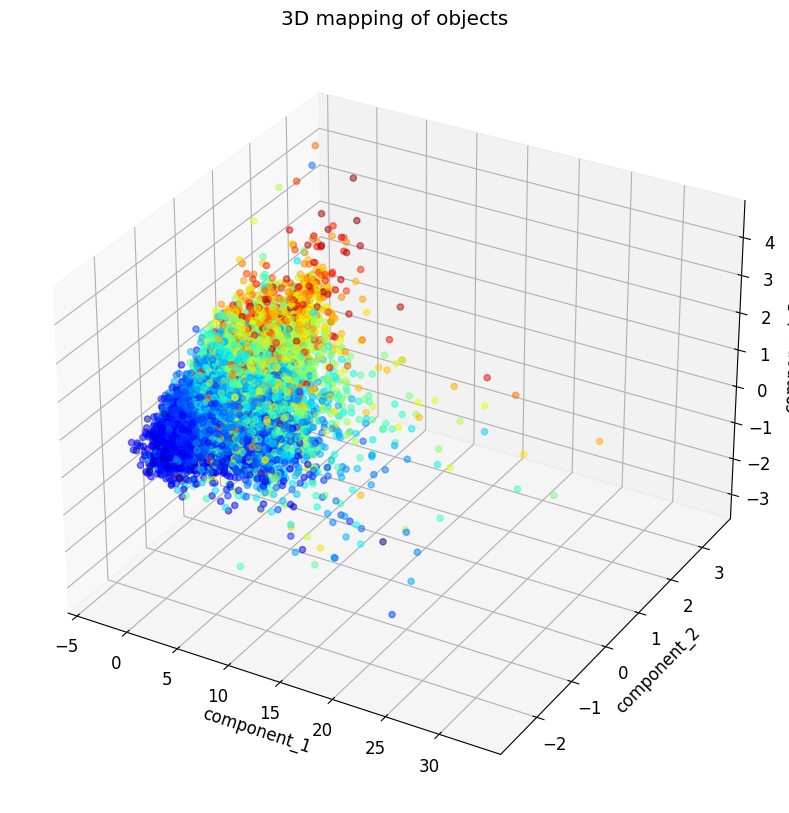

In [ ]:
display_components_in_3D_space(components_3d, y_train)

## TSNE <a class='anchor' id='tsne'>

Алгоритм t-SNE, который также относят к методам множественного обучения признаков, был опубликован в 2008 году голландским исследователем Лоуренсом ван дер Маатеном и чародеем нейронных сетей Джеффри Хинтоном. Классический SNE был предложен Хинтоном и Ровейсом в 2002 году. В статье 2008 года описывается несколько «трюков», которые позволили упростить процесс поиска глобальных минимумов, и повысить качество визуализации. Одним из них стала замена нормального распределения на распределение Стьюдента для данных низкой размерности.

Принцип работы метода t-SNE заключается в том, что он пытается сохранять расстояния между каждым входящим вектором.

Шаг 1: В многомерном пространстве создается вероятностное распределение, которое обусловлено расстоянием между точками (преобразование многомерной дистанции между точками в условные вероятности, отражающие сходство точек)

Шаг 2: Алгоритм пытается воссоздать меньше размерное пространство, в котором наилучшим образом сохраняется вероятностное распределение

In [ ]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=1)
components_2d_tsne.head(2)

CPU times: user 4min 4s, sys: 2.12 s, total: 4min 6s
Wall time: 2min 29s


component_1  component_2
0   -89.450943     2.365206
1     1.613177    30.583988

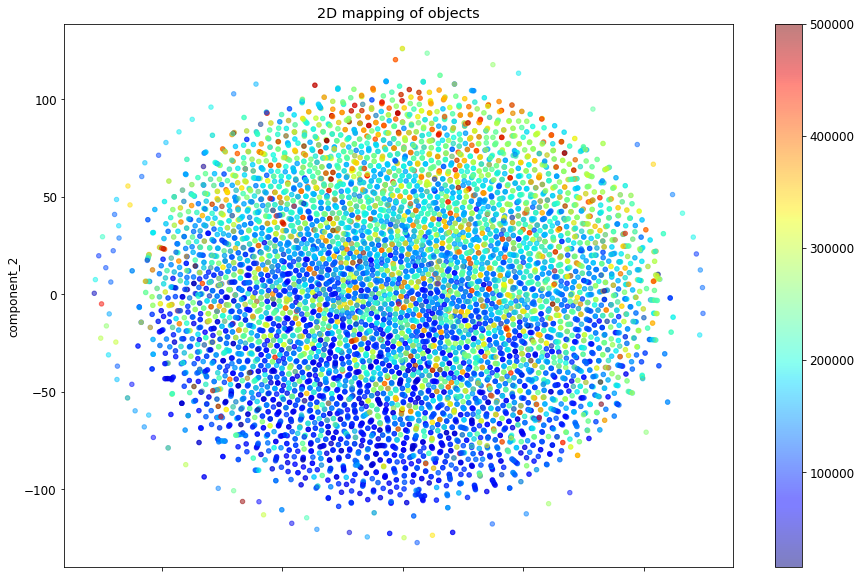

In [ ]:
display_components_in_2D_space(components_2d_tsne, y_train)

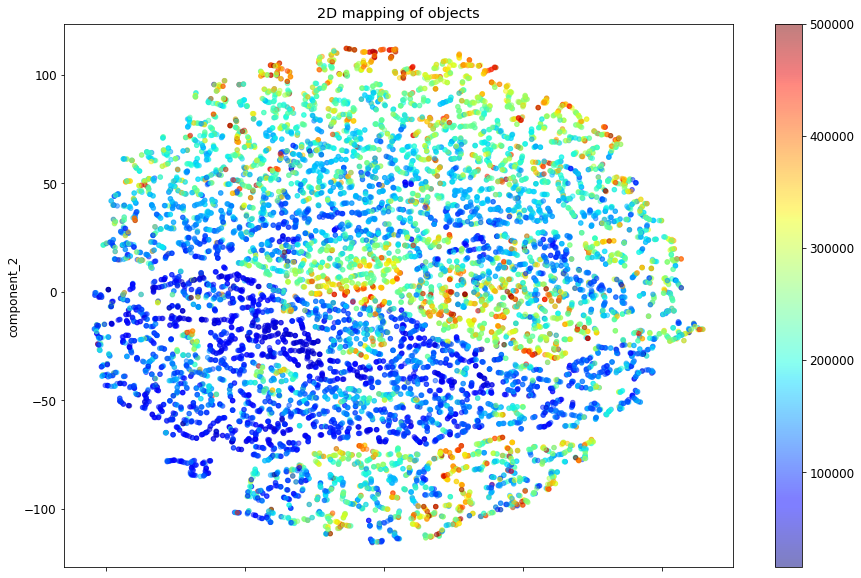

CPU times: user 2min 22s, sys: 355 ms, total: 2min 23s
Wall time: 1min 25s


In [ ]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=5)
display_components_in_2D_space(components_2d_tsne, y_train)

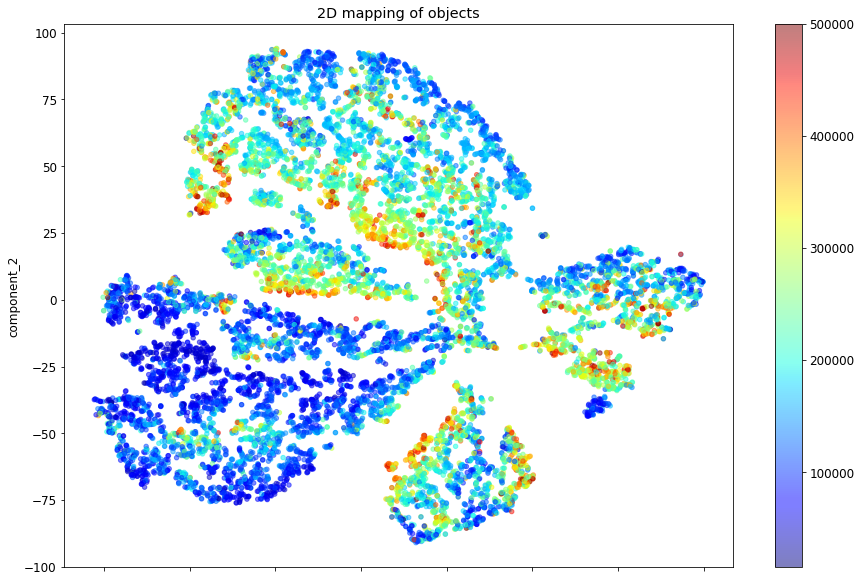

CPU times: user 2min 35s, sys: 388 ms, total: 2min 36s
Wall time: 1min 31s


In [ ]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=30)
display_components_in_2D_space(components_2d_tsne, y_train)

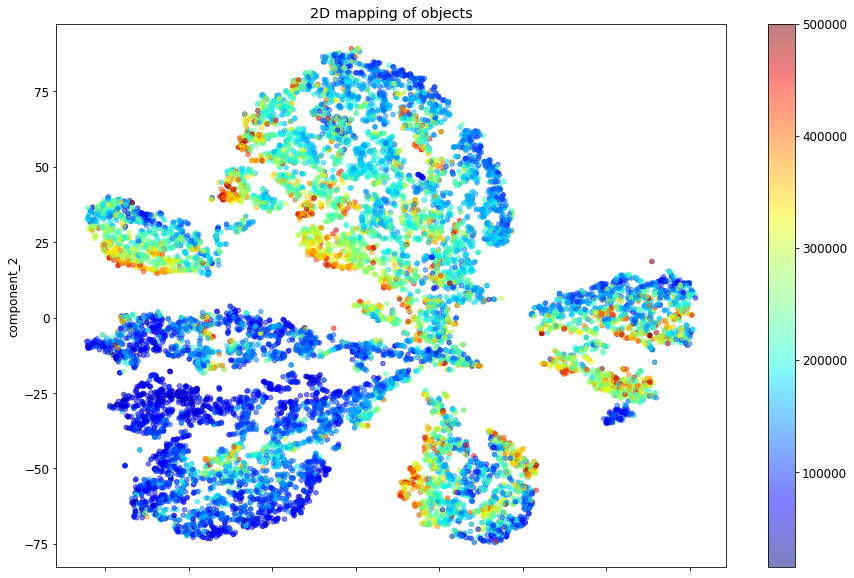

CPU times: user 2min 56s, sys: 435 ms, total: 2min 56s
Wall time: 1min 44s


In [ ]:
%%time
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=50)
display_components_in_2D_space(components_2d_tsne, y_train)

In [ ]:
%%time
dim_reducer3d_tsne, components_3d_tsne = reduce_dims(X_train_scaled, dims=3, method='tsne')
components_3d_tsne.head(2)

KeyboardInterrupt: ignored

In [ ]:
display_components_in_3D_space(components_3d_tsne, y_train)

NameError: ignored

In [ ]:
display_components_in_3D_space(components_3d_tsne, y_train)

# Кластеризация <a class='anchor' id='cluster'>

**Кластеризация** (или кластерный анализ) — это задача разбиения множества объектов на группы, называемые кластерами. Внутри каждой группы должны оказаться «похожие» объекты, а объекты разных группы должны быть как можно более отличны. Главное отличие кластеризации от классификации состоит в том, что перечень групп четко не задан и определяется в процессе работы алгоритма.

Применение кластерного анализа в общем виде сводится к следующим этапам:
Отбор выборки объектов для кластеризации.
Определение множества переменных, по которым будут оцениваться объекты в выборке. При необходимости – нормализация значений переменных.
Вычисление значений меры сходства между объектами.
Применение метода кластерного анализа для создания групп сходных объектов (кластеров).
Представление результатов анализа.

После получения и анализа результатов возможна корректировка выбранной метрики и метода кластеризации до получения оптимального результата.

**Меры расстояний**

Итак, как же определять «похожесть» объектов? Для начала нужно составить вектор характеристик для каждого объекта — как правило, это набор числовых значений, например, рост-вес человека. Однако существуют также алгоритмы, работающие с качественными (т.н. категорийными) характеристиками.

После того, как определен вектор характеристик, можно провести нормализацию, чтобы все компоненты давали одинаковый вклад при расчете «расстояния». В процессе нормализации все значения приводятся к некоторому диапазону, например, [-1, -1] или [0, 1].

Наконец, для каждой пары объектов измеряется «расстояние» между ними — степень похожести. Существует множество метрик, вот лишь основные из них:

Евклидово расстояние

Наиболее распространенная функция расстояния. Представляет собой геометрическим расстоянием в многомерном пространстве:

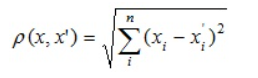

Квадрат евклидова расстояния

Применяется для придания большего веса более отдаленным друг от друга объектам. Это расстояние вычисляется следующим образом:

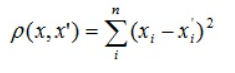

Расстояние городских кварталов (манхэттенское расстояние)

Это расстояние является средним разностей по координатам. В большинстве случаев эта мера расстояния приводит к таким же результатам, как и для обычного расстояния Евклида. Однако для этой меры влияние отдельных больших разностей (выбросов) уменьшается (т.к. они не возводятся в квадрат). Формула для расчета манхэттенского расстояния:

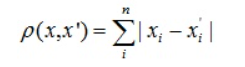

Расстояние Чебышева

Это расстояние может оказаться полезным, когда нужно определить два объекта как «различные», если они различаются по какой-либо одной координате. Расстояние Чебышева вычисляется по формуле:

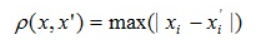

Степенное расстояние

Применяется в случае, когда необходимо увеличить или уменьшить вес, относящийся к размерности, для которой соответствующие объекты сильно отличаются. Степенное расстояние вычисляется по следующей формуле:

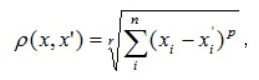

где r и p – параметры, определяемые пользователем. Параметр p ответственен за постепенное взвешивание разностей по отдельным координатам, параметр r ответственен за прогрессивное взвешивание больших расстояний между объектами. Если оба параметра – r и p — равны двум, то это расстояние совпадает с расстоянием Евклида.

Выбор метрики полностью лежит на исследователе, поскольку результаты кластеризации могут существенно отличаться при использовании разных мер.

Алгоритмы:
- K-means
- Иерархическая кластеризация
- HDBScan

### Кластеризация: k-means <a class='anchor' id='kmeans'>

**Как работает k-means**

В начале алгоритма указывается кол-во кластеров

1. Центры кластеров случайно инициализируются
2. От каждой точки рассчитывается расстояние до центра каждого кластера
3. Присваиваем каждую точку к тому кластеру, к центру которого она ближе
4. Пересчитываем центры кластеров: берем среднее по всем фичам --> новый центр кластера
    
итеративно повторяем шаги 2-4. Пока центры кластеров не перестанут "двигаться"

Хорошо работает, когда кластеры "шарообразные"

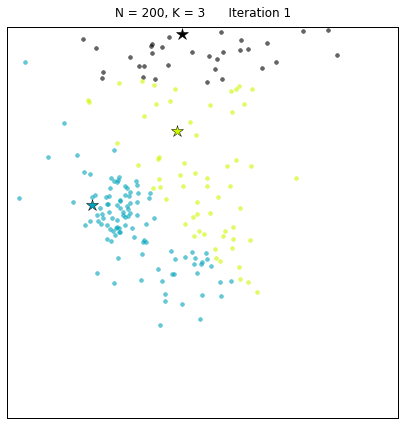

**Выделение 3 кластеров**

In [ ]:
kmeans_3 = KMeans(n_clusters=3, random_state=42)
labels_clast_3 = kmeans_3.fit_predict(X_train_scaled)
labels_clast_3 = pd.Series(labels_clast_3, name='clusters_3')
labels_clast_3_test = kmeans_3.predict(X_test_scaled)
labels_clast_3_test = pd.Series(labels_clast_3_test, name='clusters_3')

unique, counts = np.unique(labels_clast_3, return_counts=True)
display_clusters_distribution(unique, counts)

NameError: ignored

In [ ]:
labels_clast_3[:5]

0    1
1    1
2    0
3    1
4    0
Name: clusters_3, dtype: int32

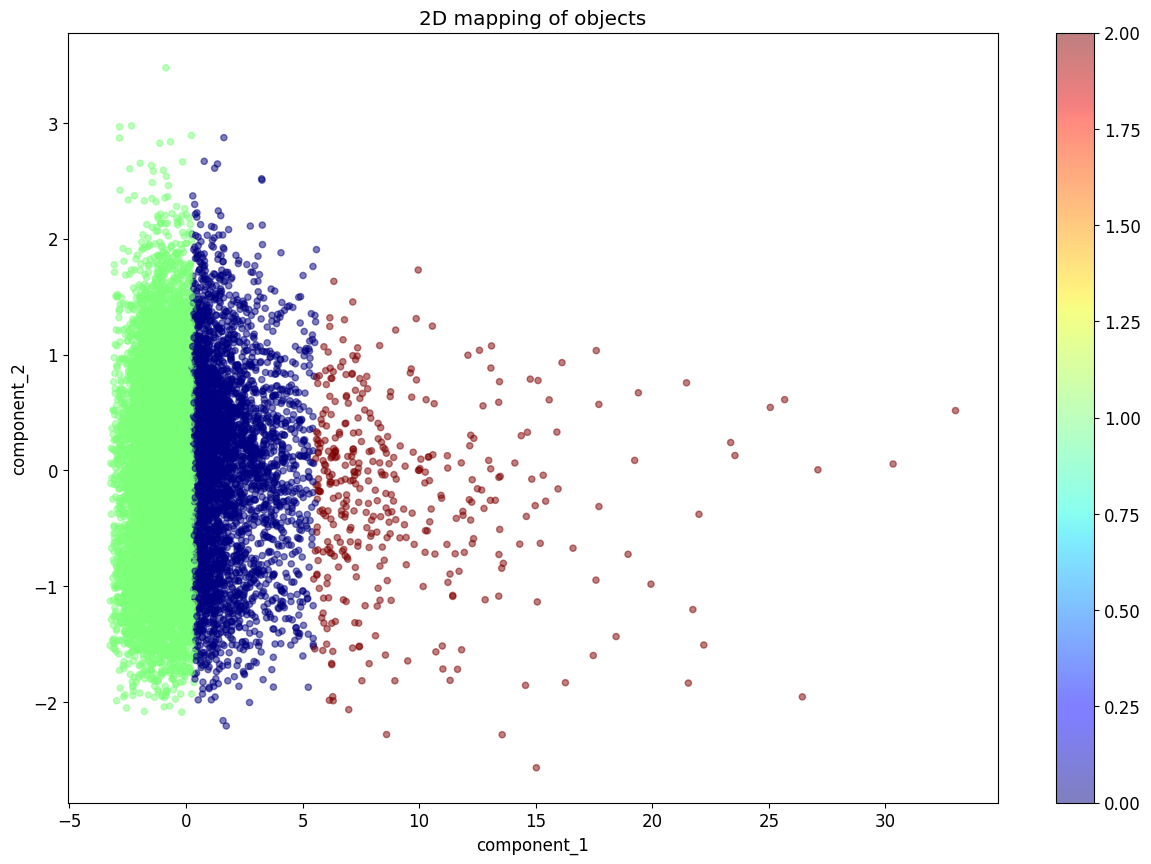

In [ ]:
display_components_in_2D_space(components_2d, labels_clast_3)

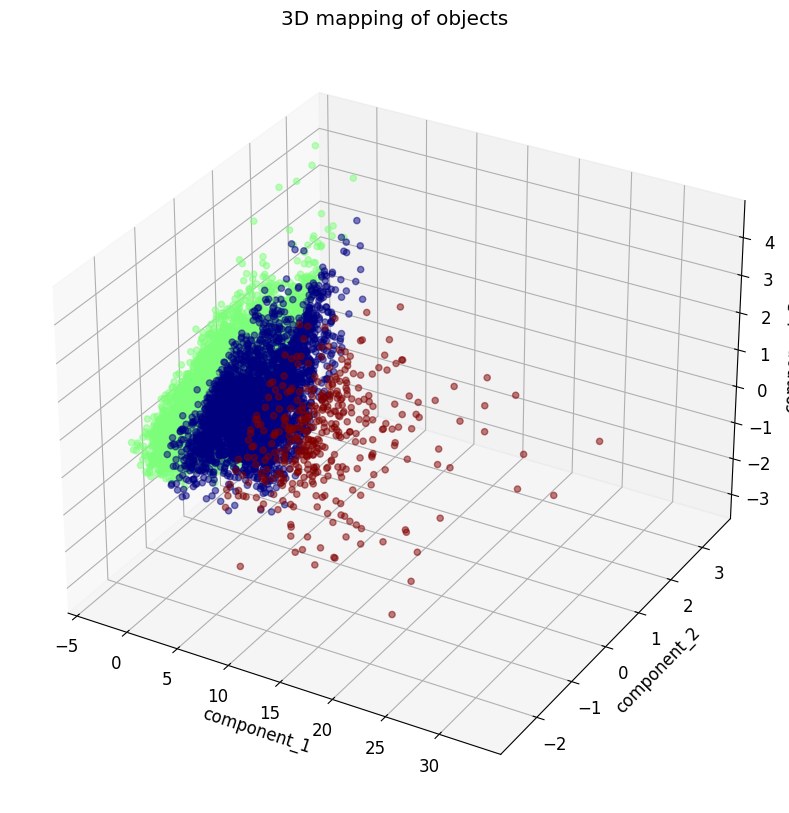

In [ ]:
display_components_in_3D_space(components_3d, labels_clast_3)

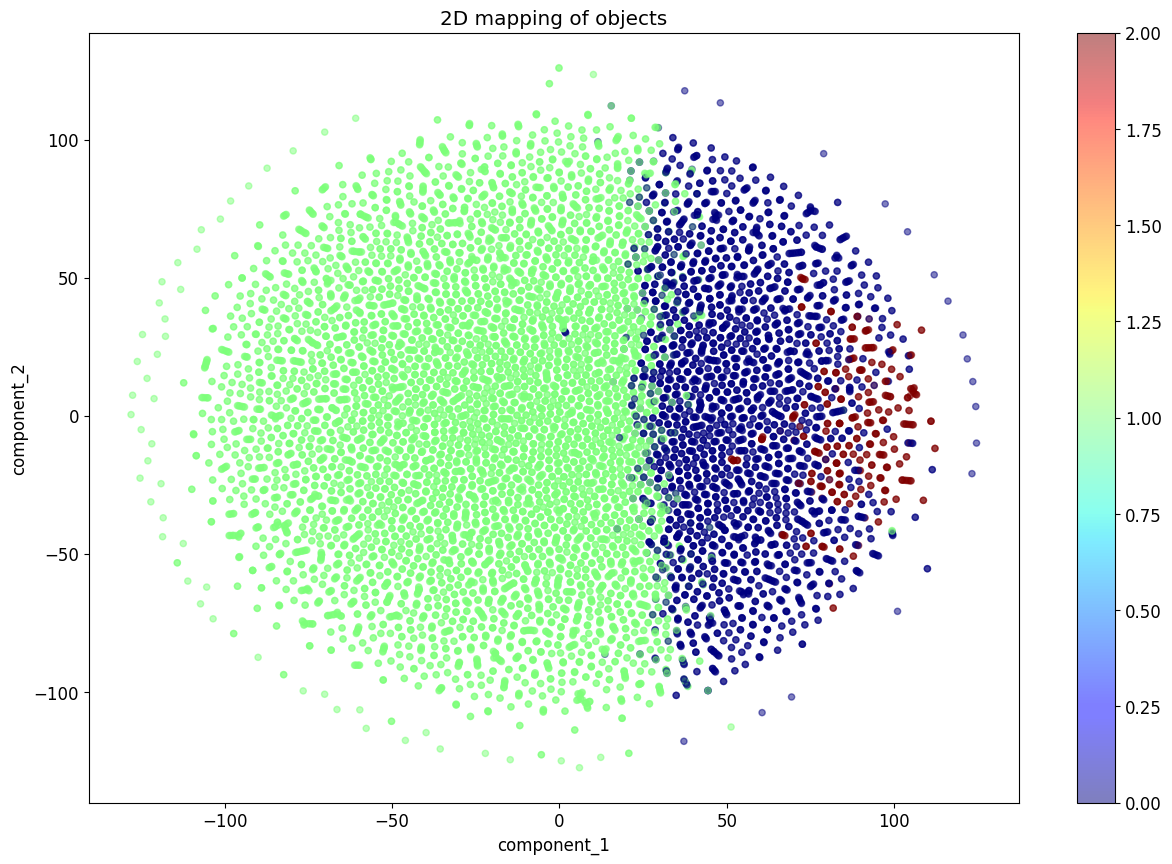

In [ ]:
display_components_in_2D_space(components_2d_tsne, labels_clast_3)

In [ ]:
kmeans_3.cluster_centers_

**Выделение 10 кластеров**

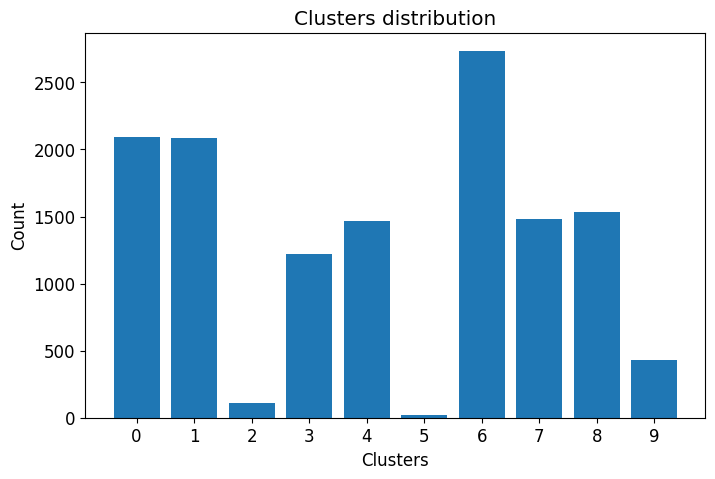

In [ ]:
kmeans_10 = KMeans(n_clusters=10, random_state=42)
labels_clast_10 = kmeans_10.fit_predict(X_train_scaled)
labels_clast_10 = pd.Series(labels_clast_10, name='clusters_10')
labels_clast_10_test = kmeans_10.predict(X_test_scaled)
labels_clast_10_test = pd.Series(labels_clast_10_test, name='clusters_10')

unique, counts = np.unique(labels_clast_10, return_counts=True)
display_clusters_distribution(unique, counts)

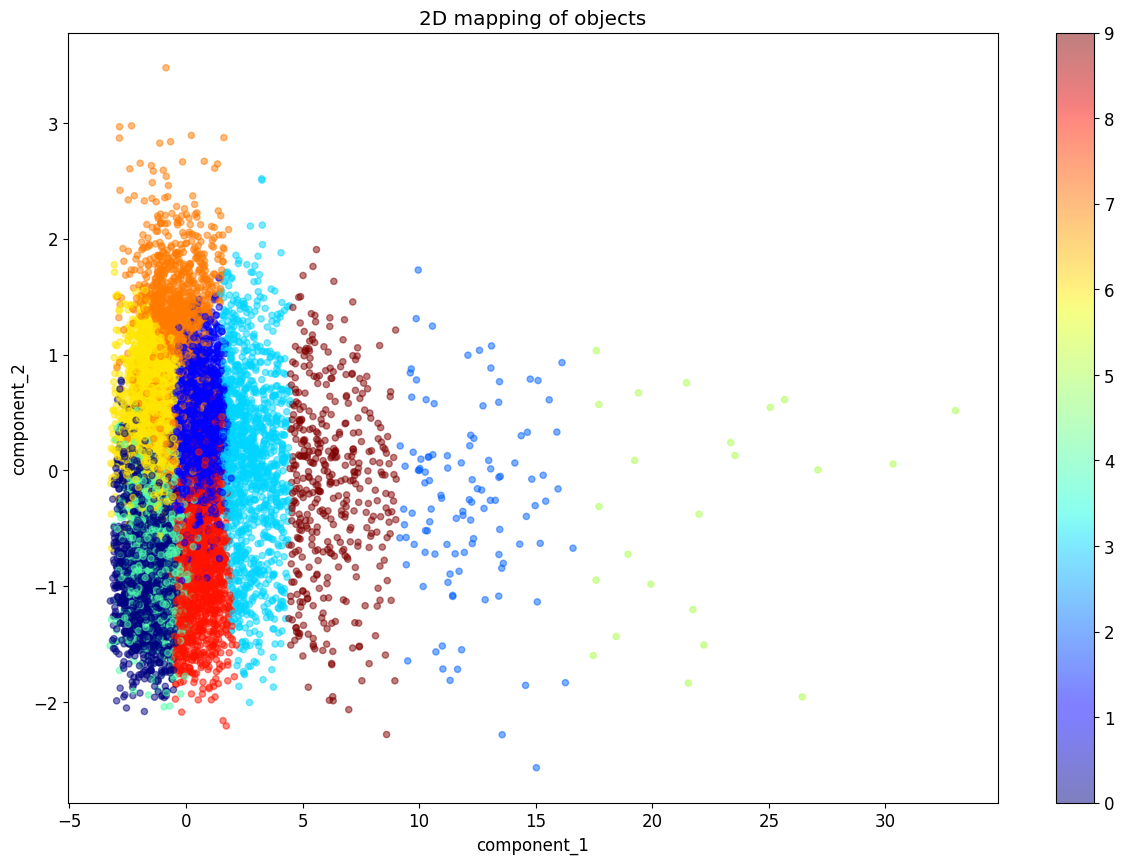

In [ ]:
display_components_in_2D_space(components_2d, labels_clast_10)

In [ ]:
display_components_in_2D_space(components_2d_tsne, labels_clast_10)

### Оценка оптимального кол-ва кластеров

Дисперсия точек вокруг цетров кластеров

In [ ]:
print(inspect.getsource(apply_elbow_method))

def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()



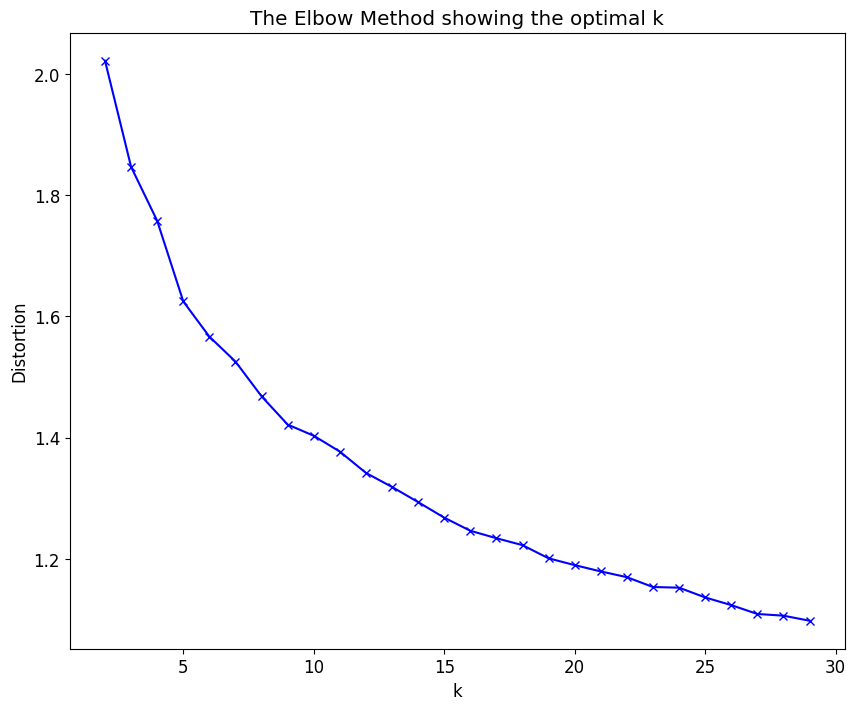

In [ ]:
apply_elbow_method(X_train_scaled)

### Добавление новых признаков

In [ ]:
clusters_3_dummies = pd.get_dummies(labels_clast_3, drop_first=True, prefix='clusters_3')
clusters_10_dummies = pd.get_dummies(labels_clast_10, drop_first=True, prefix='clusters_10')

X_train_scaled = pd.concat([X_train_scaled, components_3d, clusters_3_dummies, clusters_10_dummies],
                   axis=1)
X_train_scaled.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.198413  0.245383           -1.388889    -1.254978       -1.251445   
1   0.230159 -0.068602           -0.722222     0.551857        0.257225   
2   0.111111 -0.060686            0.166667     0.987519        1.014451   
3  -1.108466  1.097625           -0.500000     0.478752        0.210983   
4   0.444444 -0.372032           -0.666667     2.190490        1.404624   

   population  households  median_income  <1H OCEAN  INLAND  ...  \
0   -1.265284   -1.264615      -0.516324        0.0     1.0  ...   
1    0.383188    0.190769       0.715002        0.0     1.0  ...   
2    0.000000    1.166154       0.113877        1.0     0.0  ...   
3    0.596070    0.267692       0.217890        1.0     0.0  ...   
4    1.599345    1.323077       0.794200        1.0     0.0  ...   

   clusters_3_2  clusters_10_1  clusters_10_2  clusters_10_3  clusters_10_4  \
0             0              0              0              0              0   
1             0              0              0              0              0   
2             0              1              0              0              0   
3             0              0              0              0              0   
4             0              0              0              1              0   

   clusters_10_5  clusters_10_6  clusters_10_7  clusters_10_8  clusters_10_9  
0              0              0              0              0              0  
1              0              0              1              0              0  
2              0              0              0              0              0  
3              0              0              0              1              0  
4              0              0              0              0              0  

[5 rows x 26 columns]

In [ ]:
clusters_3_dummies_test = pd.get_dummies(labels_clast_3_test, drop_first=True, prefix='clusters_3')
clusters_10_dummies_test = pd.get_dummies(labels_clast_10_test, drop_first=True, prefix='clusters_10')

X_test_scaled = pd.concat([X_test_scaled, components_3d_test, clusters_3_dummies_test, clusters_10_dummies_test],
                   axis=1)
X_test_scaled.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   0.417989 -0.390501           -0.277778     0.225557        0.745665   
1   0.370370 -0.356201           -0.833333    -0.099554        0.080925   
2   0.330688 -0.036939            1.277778    -0.255869       -0.488439   
3  -1.447090  1.765172           -0.444444    -0.356909       -0.335260   
4  -0.751323  1.145119            0.000000     0.141753        0.505780   

   population  households  median_income  <1H OCEAN  INLAND  ...  \
0    0.278384    0.707692      -0.780299        1.0     0.0  ...   
1    0.043668   -0.070769       0.382305        1.0     0.0  ...   
2   -0.566594   -0.483077       0.302619        0.0     1.0  ...   
3   -0.242358   -0.344615       0.052937        1.0     0.0  ...   
4   -0.041485    0.550769      -0.601982        0.0     1.0  ...   

   clusters_3_2  clusters_10_1  clusters_10_2  clusters_10_3  clusters_10_4  \
0             0              1              0              0              0   
1             0              0              0              0              0   
2             0              0              0              0              0   
3             0              0              0              0              1   
4             0              0              0              0              0   

   clusters_10_5  clusters_10_6  clusters_10_7  clusters_10_8  clusters_10_9  
0              0              0              0              0              0  
1              0              0              1              0              0  
2              0              1              0              0              0  
3              0              0              0              0              0  
4              0              0              0              1              0  

[5 rows x 26 columns]

### Переобучение и оценка финальной модели

In [ ]:
final_model = GradientBoostingRegressor(criterion='squared_error',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)
final_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(criterion='squared_error', max_depth=7,
                          min_samples_leaf=10, n_estimators=400,
                          random_state=42)

R2:	0.956
MAE:	14081.72
MSE:	411996482.053


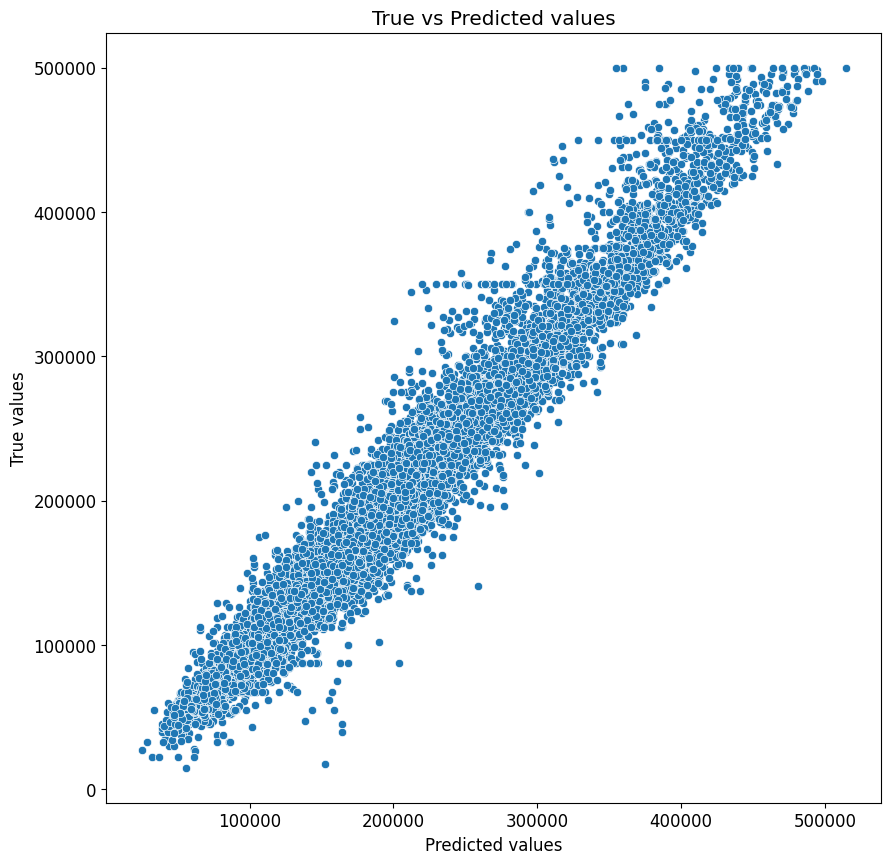

In [ ]:
y_train_preds = final_model.predict(X_train_scaled)
evaluate_preds(y_train, y_train_preds)

R2:	0.811
MAE:	29078.867
MSE:	1842294894.949


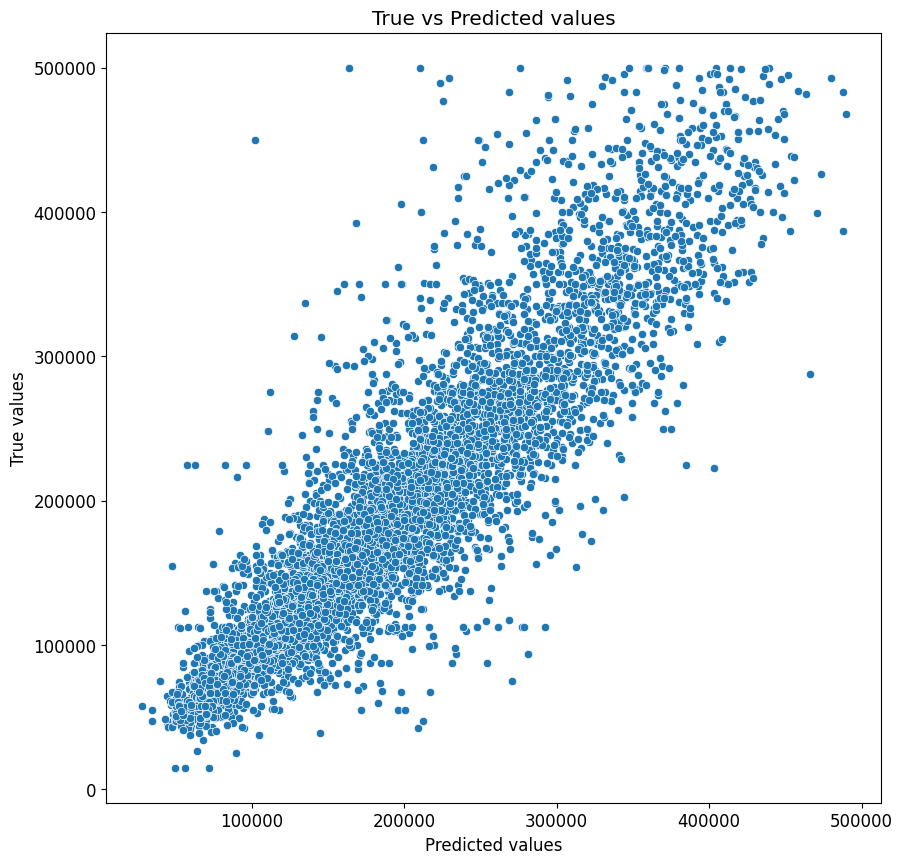

In [ ]:
y_test_preds = final_model.predict(X_test_scaled)
evaluate_preds(y_test, y_test_preds)

*Без фичей с кластерами было 0.808

### Кластеризация: DBSCAN <a class='anchor' id='dbscan'>

Кол-во кластеров не указывается.

**Ключевые моменты:**
1. $\epsilon$ - радиус окружности
2. *min_samples* - количество точек, которые попали в границы окружности
3. *сore points* - ключевые точки (в их окружность попало не менее *min_samples* точек)
4. *border points* - граничные точки (в их окружность попало менее *min_samples* точек, но есть хотя бы одна *core point*)
5. *noise points* - выбросы (в их окружность не попала *core point*)

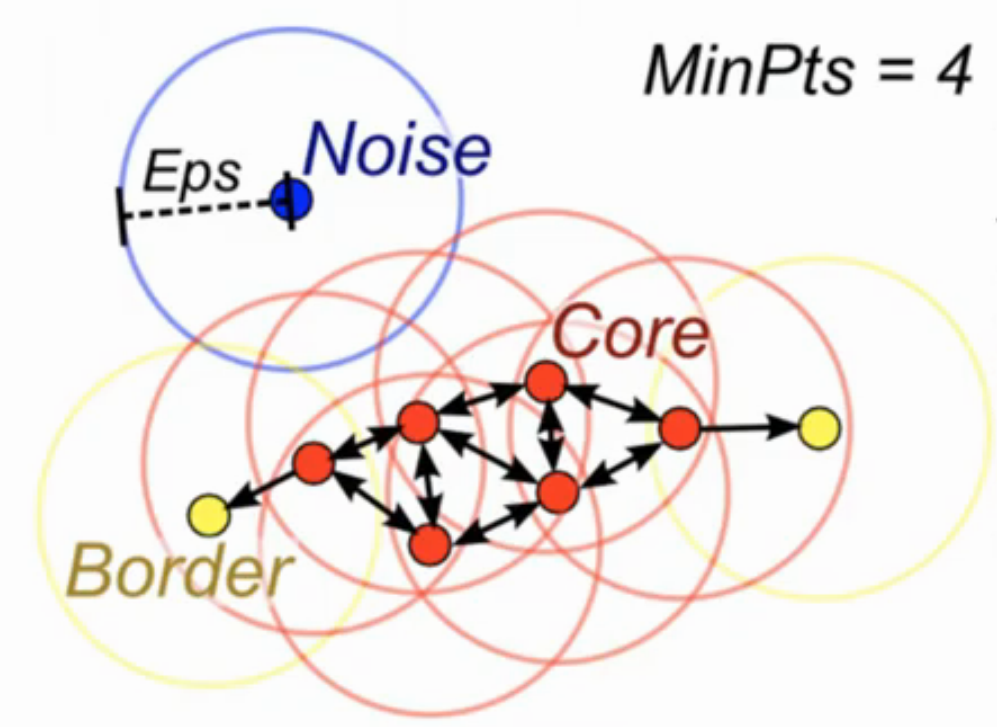

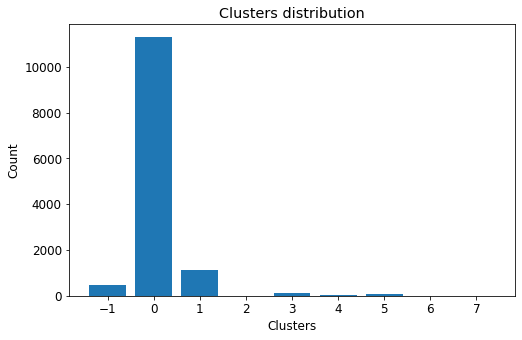

In [ ]:
dbscan = DBSCAN(eps=1.35, min_samples=7)
labels_clast = dbscan.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_dbscan')

# labels_clast_test = dbscan.predict(X_test_scaled)
# labels_clast_test = pd.Series(labels_clast_test, name='clusters_dbscan')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, labels_clast)

labels_clast_test = knn.predict(X_test_scaled)

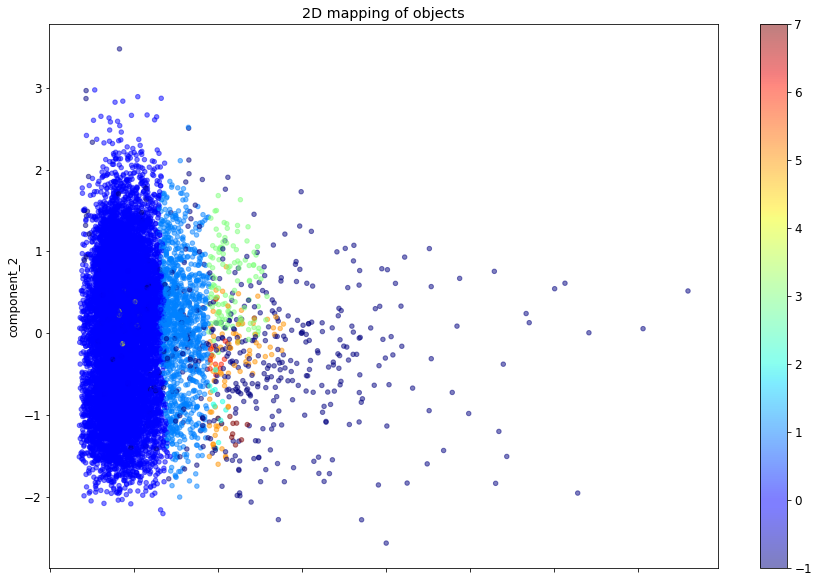

In [ ]:
display_components_in_2D_space(components_2d, labels_clast)

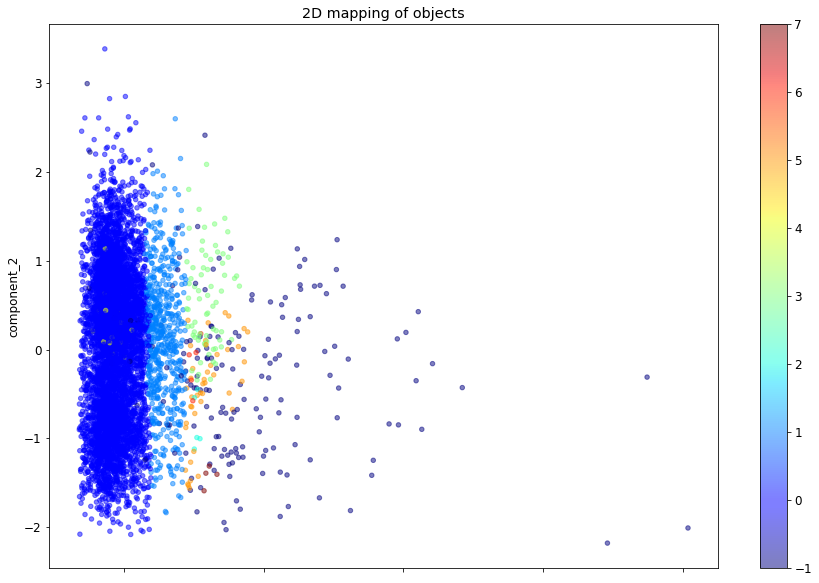

In [ ]:
display_components_in_2D_space(components_2d_test, labels_clast_test)

In [ ]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

NameError: ignored

### Кластеризация: Иерархическая <a class='anchor' id='aggl'>
**Агломеративная**

Кол-во кластеров указывается.

**Алгоритм**:
1. Считаем, что каждая точка - кластер
2. Сортируем попарные расстояния между центрами кластеров по возрастанию
3. Пару ближайших кластеров склеиваем в один и пересчитываем центр кластера
4. Повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

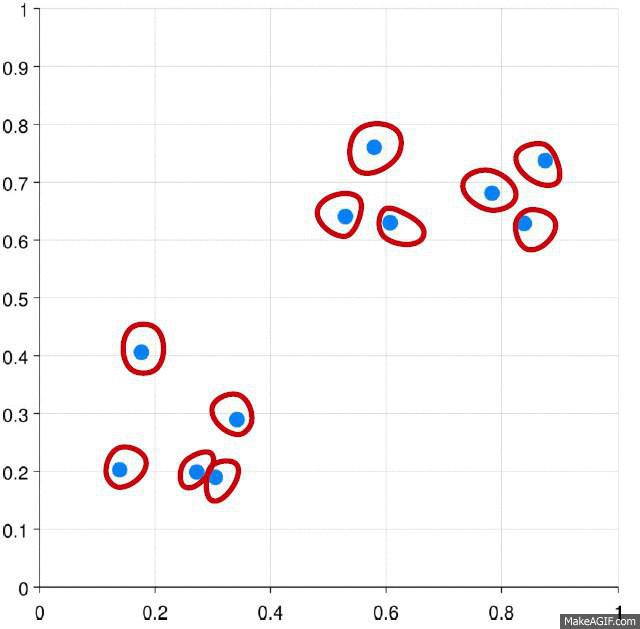

**Методы объединения точек:**
* Single linkage — минимум попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=min||x_i−x_j||$

* Complete linkage — максимум попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=max||x_i−x_j||$

* Average linkage — среднее попарных расстояний между точками из двух кластеров
$d(C_i,C_j)=\frac{1}{n_in_j}∑_{x_i∈C_i}∑_{x_j∈C_j}||xi−xj||$
* Centroid linkage — расстояние между центроидами двух кластеров
$d(C_i,C_j)=||μ_i−μ_j||$

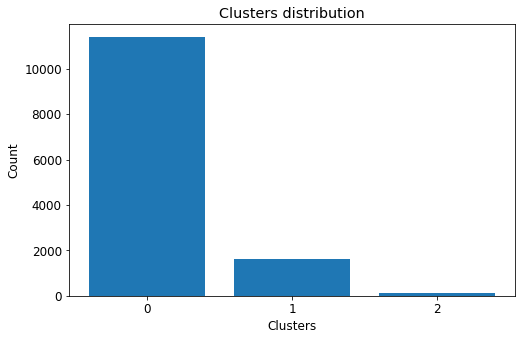

CPU times: user 9.98 s, sys: 932 ms, total: 10.9 s
Wall time: 10.8 s


In [ ]:
%%time
aggl = AgglomerativeClustering(n_clusters=3)
labels_clast = aggl.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_aggl')

# labels_clast_test = aggl.predict(X_test_scaled)
# labels_clast_test = pd.Series(labels_clast_test, name='clusters_aggl')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, labels_clast)

labels_clast_test = knn.predict(X_test_scaled)

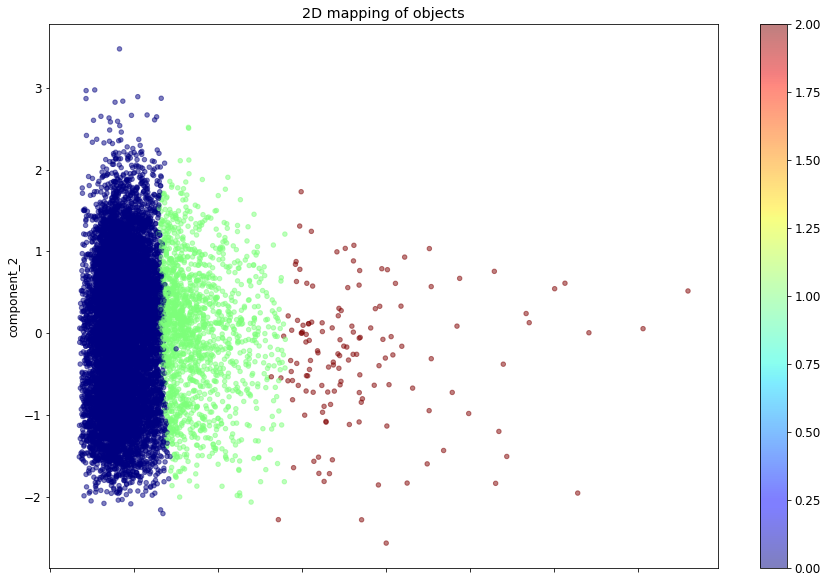

In [ ]:
display_components_in_2D_space(components_2d, labels_clast)

In [ ]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

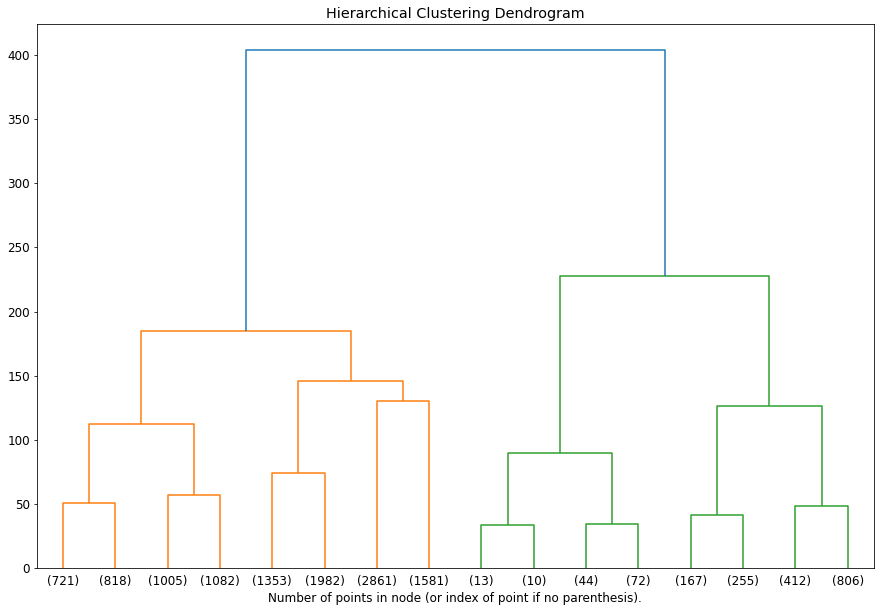

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_train_scaled)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Более наглядный пример <a class='anchor' id='example'>

Визуализация набора данных MNIST.

In [ ]:
from sklearn import datasets


digits = datasets.load_digits()
X = digits.data
y = digits.target

In [ ]:
X.shape

(1797, 64)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
y[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

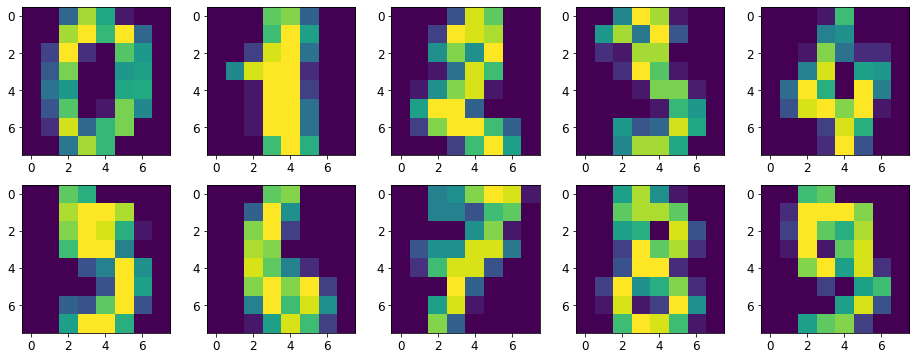

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]))

**PCA**

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

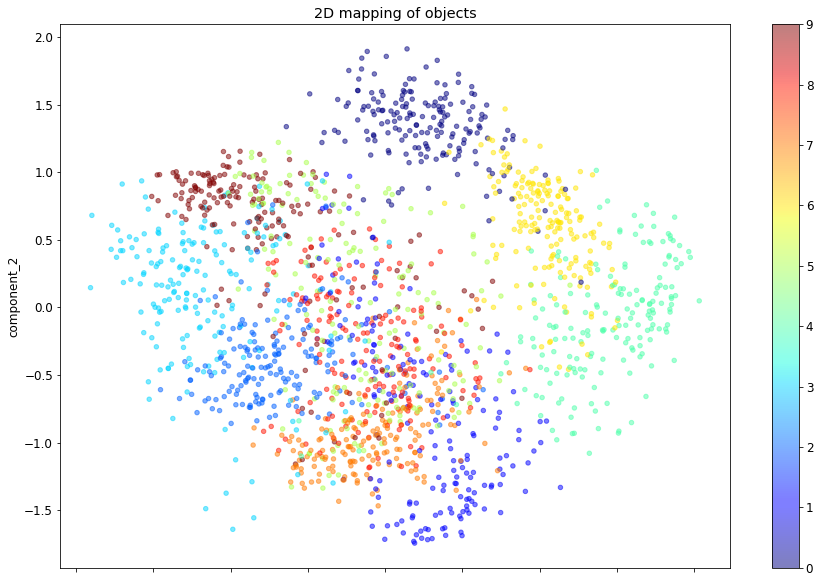

In [ ]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_reduced = pd.DataFrame(data=X_reduced, columns=colnames)
components_X_reduced.head()

display_components_in_2D_space(components_X_reduced, labels=y)

**TSNE**

In [ ]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17, perplexity=25)

X_tsne = tsne.fit_transform(X)

CPU times: user 15.5 s, sys: 101 ms, total: 15.6 s
Wall time: 8.84 s


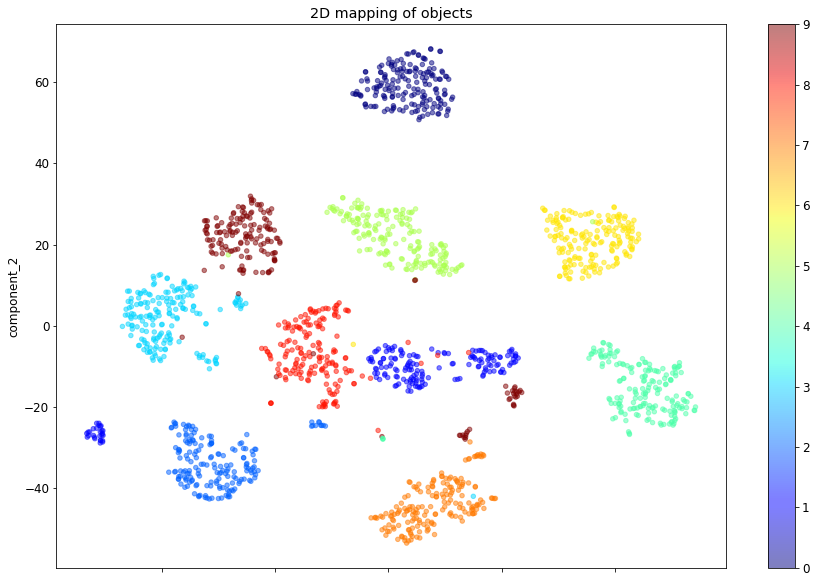

In [ ]:
dims = 2
colnames = ['component_' + str(i) for i in range(1, dims+1)]
components_X_tsne = pd.DataFrame(data=X_tsne, columns=colnames)
components_X_tsne.head()

display_components_in_2D_space(components_X_tsne, labels=y)

**KMeans**

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
labels_clast = kmeans.fit_predict(X)
labels_clast = pd.Series(labels_clast, name='clusters')

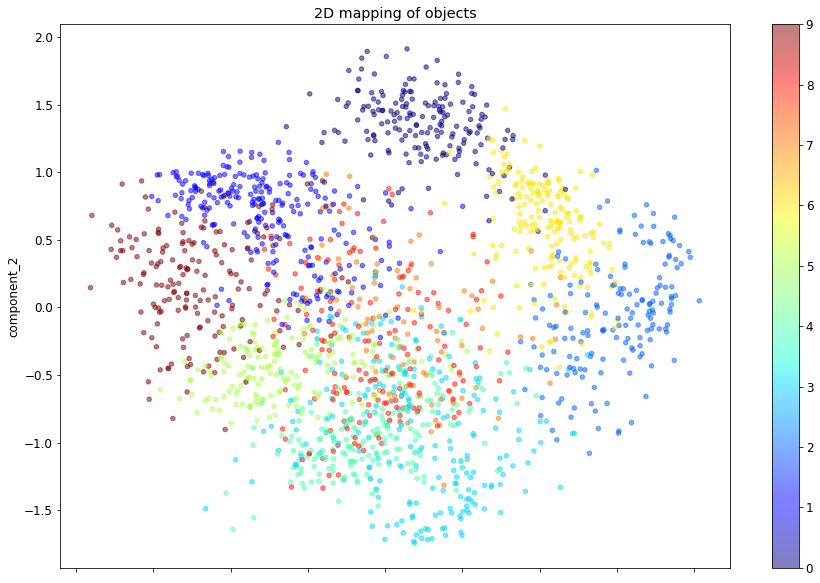

In [ ]:
display_components_in_2D_space(components_X_reduced, labels=labels_clast)

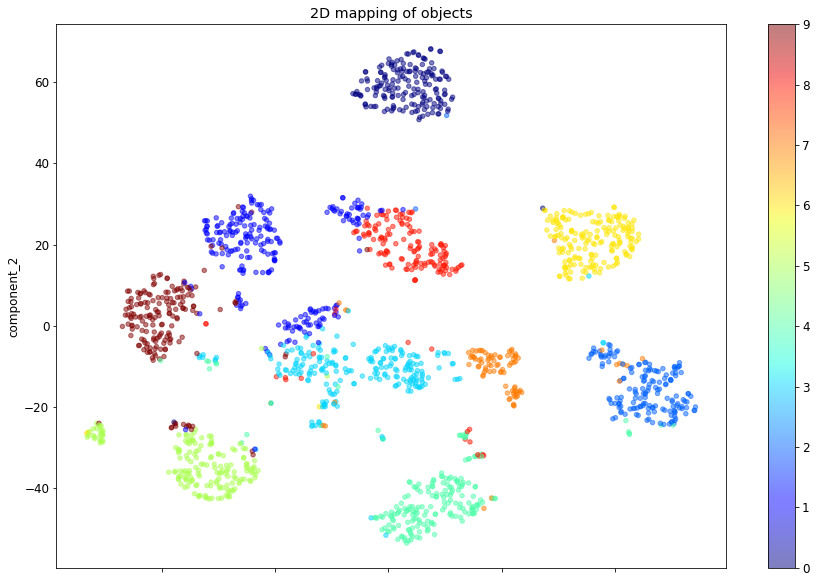

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

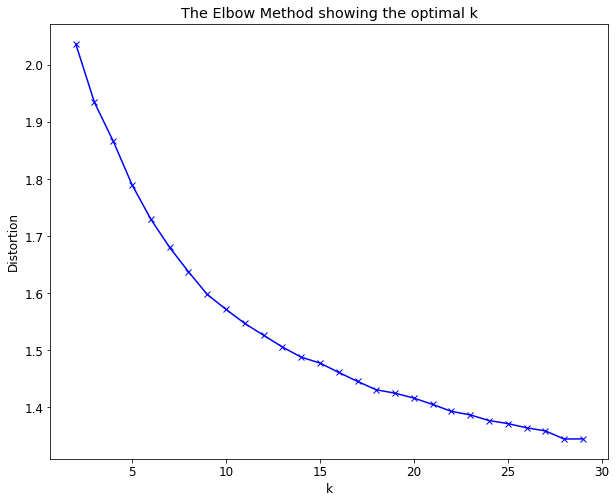

In [ ]:
apply_elbow_method(X)

**DBSCAN**

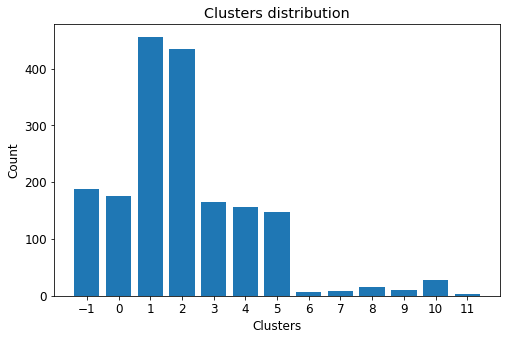

In [ ]:
dbscan = DBSCAN(eps=1.4, min_samples=4)
labels_clast = dbscan.fit_predict(X)
labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

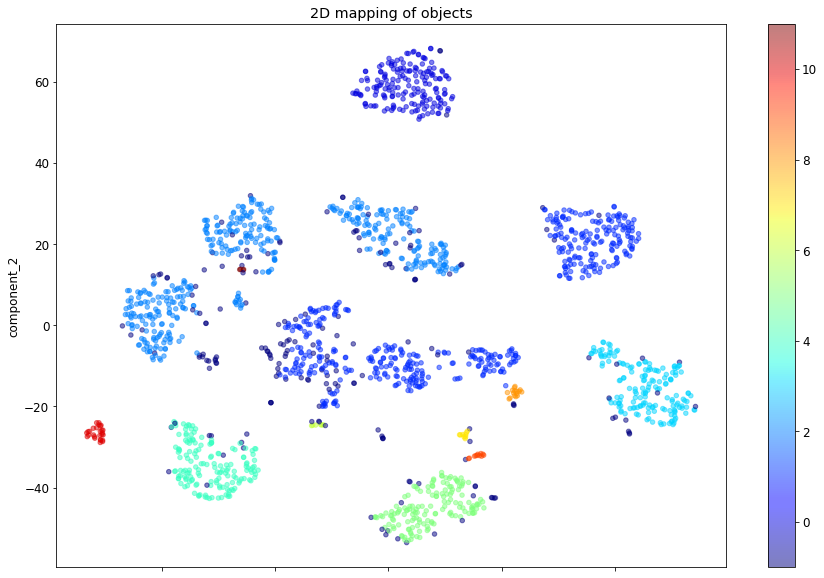

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

**AgglomerativeClustering**

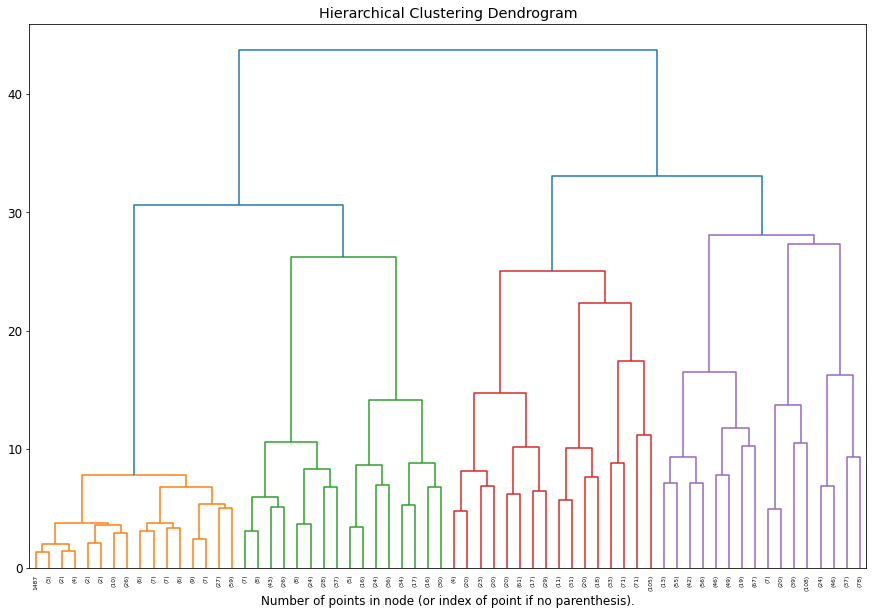

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram

plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

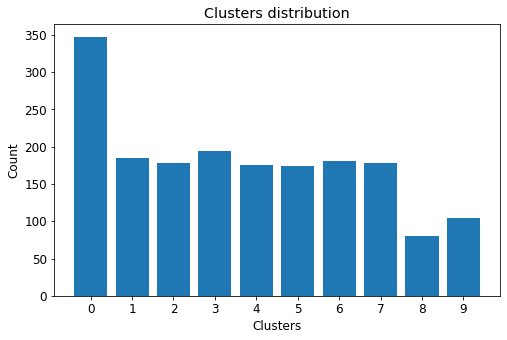

CPU times: user 363 ms, sys: 27 ms, total: 390 ms
Wall time: 473 ms


In [ ]:
%%time
aggl = AgglomerativeClustering(n_clusters=10)
labels_clast = aggl.fit_predict(X)
labels_clast = pd.Series(labels_clast)

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

In [ ]:
# display_components_in_2D_space(components_X_tsne, labels=y)

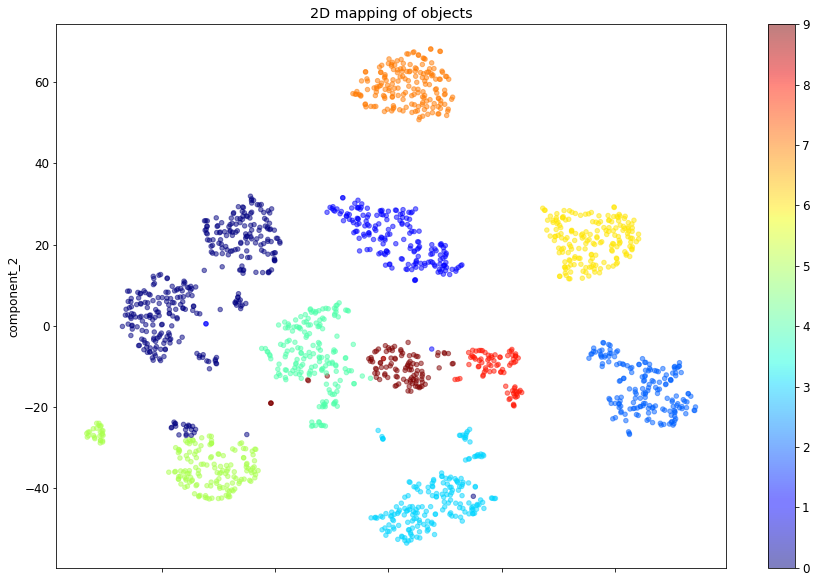

In [ ]:
display_components_in_2D_space(components_X_tsne, labels=labels_clast)

### Задание <a class='anchor' id='course'>

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача задания:
1. ноутбук
2. Необходимо получить R2 > 0.7 (на тестовой выборке).

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. составить сравнитеьную таблицу моделей, использующих разные методы обучения.
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне.